In [1]:
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from matplotlib.pyplot import imshow
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def RGBtoYCC(arr):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = arr.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [3]:
def YCCtoRGB(arr):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = arr.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [4]:
def RGBtoGray(arr):
    ycc = RGBtoYCC(arr)
    ret = np.zeros_like(ycc)
    ret[:, :, 0] = ycc[:, :, 0]
    ret[:, :, 1] = ycc[:, :, 0]
    ret[:, :, 2] = ycc[:, :, 0]
    return ret

In [5]:
def YCCtoGray(arr):
    ret = np.zeros_like(arr)
    ret[:, :, 0] = arr[:, :, 0]
    ret[:, :, 1] = arr[:, :, 0]
    ret[:, :, 2] = arr[:, :, 0]
    return ret

In [6]:
def crop_center(img, cropx, cropy):
    y, x, C = img.shape
    if y > cropy and x > cropx:
        startx = x//2 - (cropx//2)
        starty = y//2 - (cropy//2)    
        return img[starty:starty+cropy, startx:startx+cropx, :]
    else:
        return None

In [17]:
def top_left_coord(img, cropx, cropy):
    y, x, C = img.shape
    if y > cropy and x > cropx:
        startx = x//2 - (cropx//2)
        starty = y//2 - (cropy//2)
        return startx, starty
    return None, None

In [7]:
train_dir = './train2017/'

image_names = os.listdir(train_dir)
print(len(image_names))

%matplotlib inline

117285


In [22]:
# some of the images might not be the right size
# these are the dimenions with which we are working
H = 256
W = 256
C = 3

H_small = 128
W_small = 128

In [84]:
def process_image(arr, H, W, H_small, W_small):
    if len(arr.shape) == 3:
        cropped = crop_center(arr, H, W)
        if cropped is not None:
            arr = RGBtoYCC(cropped)
            arr = np.divide(arr, 255)
            gray = YCCtoGray(arr)
            gray_center = np.copy(crop_center(gray, H_small, W_small))
            avg = np.mean(gray_center)
            startx, starty = top_left_coord(gray, H_small, W_small)
            gray[starty:starty+W_small, startx:startx+H_small, :] = avg
            return gray_center, gray,  arr[:, :, 1:]
        return None, None, None
    return None, None, None

In [85]:
def generator(image_folder, batch_size):
    batch_x = np.zeros((batch_size, H, W, C))
    batch_x_center = np.zeros((batch_size, H_small, W_small, C))
    batch_labels = np.zeros((batch_size, H, W, C - 1))
    
    filenames = os.listdir(image_folder)
    
    while True:
        count = 0
        while count < batch_size:
            filename = random.choice(filenames)
            arr = np.load(os.path.join(image_folder, filename))
            x_center, x, y = process_image(arr, H, W, H_small, W_small)
            if x is not None:
                batch_x[count, :, :, :] = x
                batch_x_center[count, :, :, :] = x_center
                count += 1
        yield [batch_x_center, batch_x], batch_labels

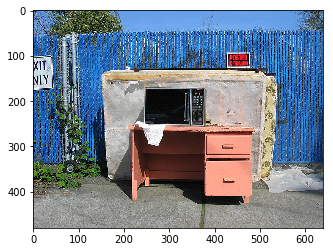

In [56]:
random_example = np.load("./train2017/000000436023.npy")
imshow(random_example)

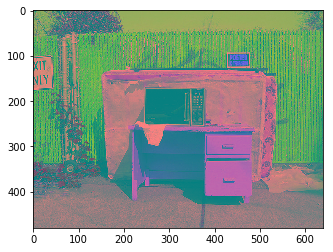

In [57]:
imshow(RGBtoYCC(random_example))

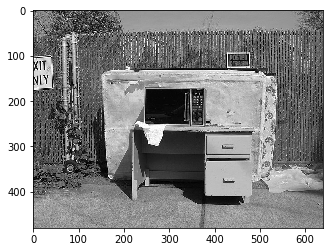

In [58]:
imshow(RGBtoGray(random_example))

In [125]:
x_center, x, y = process_image(random_example, H, W, H_small, W_small)

(256, 256, 3)


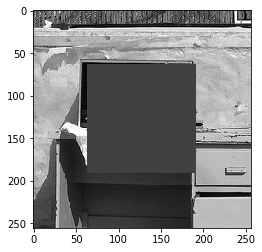

In [126]:
# the x
print(x.shape)
imshow(x)

(128, 128, 3)


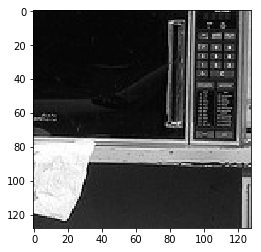

In [127]:
# the center
print(x_center.shape)
imshow(x_center)

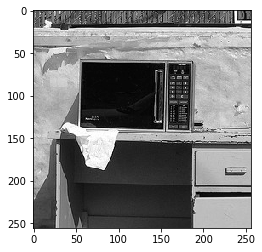

In [130]:
def get_original_x(x_center, x):
    H, W, C = x.shape
    H_small, W_small, C = x_center.shape
    ret = np.copy(x)
    startx, starty = top_left_coord(x, H_small, W_small)
    ret[starty:starty+W_small, startx:startx+H_small, :] = x_center[:, :, :]
    return ret
imshow(get_original_x(x_center, x))

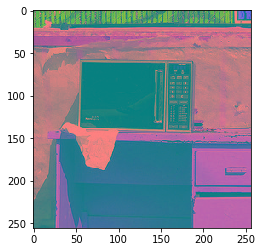

In [115]:
# the y
showing = np.zeros((y.shape[0], y.shape[1], y.shape[2] + 1))
showing[:, :, 0] = x[:, :, 0]
startx, starty = top_left_coord(showing, H_small, W_small)
showing[starty:starty+W_small, startx:startx+H_small, 0] = x_center[:, :, 0]
showing[:, :, 1:] = y
imshow(showing)

In [105]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 10

print('Using device: ', device)

Using device:  /device:GPU:0


In [149]:
model_file = 'model_gist.json'
weights_file = 'weights_gist.h5'
model_path = os.path.join("./", model_file)
weights_path = os.path.join("./", weights_file)
use_saved = False
save = True
train = True

In [150]:
input_shape_1 = (H_small, W_small, C)
input_shape_2 = (H, W, C)

def my_loss_function(y_true, y_pred):
    N = tf.shape(y_true)[0]
    y_true = tf.reshape(y_true, (N, -1))
    y_pred = tf.reshape(y_pred, (N, -1))
    square = tf.keras.backend.square(y_true - y_pred)
    summed = tf.keras.backend.sum(square, axis=1)
    meaned = tf.keras.backend.sum(summed, axis=0) / tf.cast(tf.shape(y_true)[0], tf.float32)
    return meaned

def my_loss_function_np(y_true, y_pred):
    N = y_true.shape[0]
    y_true = np.reshape(y_true, (N, -1))
    y_pred = np.reshape(y_pred, (N, -1))
    square = (y_true - y_pret) * (y_true - y_pred)
    summed = np.sum(square, axis=1)
    meaned = np.mean(summed, axis=0)

In [158]:
model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                    input_shape=input_shape_1)
for layer in model.layers:
    layer.trainable = False

inter_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
inter1 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[0]).output)
inter2 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[1]).output)
inter3 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[2]).output)
inter4 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[3]).output)

inter1_scale = H // inter1.output_shape[1]
inter2_scale = H // inter2.output_shape[1]
inter3_scale = H // inter3.output_shape[1]
inter4_scale = H // inter4.output_shape[1]

inter1Up = tf.keras.layers.UpSampling2D(size=inter1_scale)(inter1.output)
inter2Up = tf.keras.layers.UpSampling2D(size=inter2_scale)(inter2.output)
inter3Up = tf.keras.layers.UpSampling2D(size=inter3_scale)(inter3.output)
inter4Up = tf.keras.layers.UpSampling2D(size=inter4_scale)(inter4.output)
print(inter1Up, inter2Up, inter3Up, inter4Up)

hyper = tf.keras.layers.Concatenate(axis=-1)([inter1Up, inter2Up, inter3Up, inter4Up])
print(hyper)

surrounding_input = tf.keras.layers.Input(shape=(input_shape_2))
conv = tf.keras.layers.Conv2D(128, (5, 5), activation="relu", padding="same")(surrounding_input)
conv = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(conv)
conv = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(conv)

concat = tf.keras.layers.Concatenate(axis=-1)([hyper, conv])
concat = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(concat)
concat = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(concat)
out = tf.keras.layers.Conv2D(2, (3, 3), activation="relu", padding="same")(concat)


my_model = None
if os.path.isfile(model_path) and os.path.isfile(weights_path) and use_saved:
    json_string = None
    with open(model_path, 'r') as f:
        json_string = json.load(f)
    my_model = tf.keras.models.model_from_json(json_string)
    my_model.load_weights(weights_path)
    print("loaded from save")
else:
    my_model = tf.keras.models.Model(inputs=[model.input, surrounding_input], outputs=out)

my_model.summary()

my_model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

if train:
    history = my_model.fit_generator(generator(train_dir, 4), steps_per_epoch=10, epochs=2)

if save:
    json_str = my_model.to_json()
    with open(model_path, 'w') as outfile:
        json.dump(json_str, outfile)
    my_model.save_weights(weights_path)
    print("saved weights and model")




Tensor("up_sampling2d_84/ResizeNearestNeighbor:0", shape=(?, 256, 256, 64), dtype=float32) Tensor("up_sampling2d_85/ResizeNearestNeighbor:0", shape=(?, 256, 256, 128), dtype=float32) Tensor("up_sampling2d_86/ResizeNearestNeighbor:0", shape=(?, 256, 256, 256), dtype=float32) Tensor("up_sampling2d_87/ResizeNearestNeighbor:0", shape=(?, 256, 256, 512), dtype=float32)
Tensor("concatenate_38/concat:0", shape=(?, 256, 256, 960), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_40[0][0]                   
_______________________________________________________________

32206.523829296417


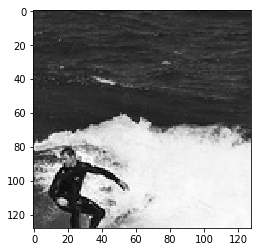

In [159]:
image_name = random.choice(image_names)
showoff = np.load(os.path.join("./train2017/", image_name))
showoff_x_center, showoff_x, showoff_y = process_image(showoff, H, W, H_small, W_small)
prediction = my_model.predict([showoff_x_center[np.newaxis, :, :, :], showoff_x[np.newaxis, :, :, :]])
prediction = np.squeeze(prediction)
original_x = get_original_x(showoff_x_center, showoff_x)
print(np.sum((prediction - showoff_y)**2))
imshow(showoff_x_center)

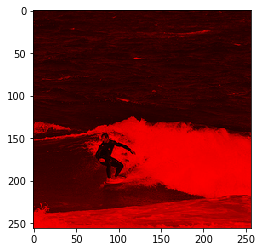

In [160]:
# visualize, after doing some shift and scaling
# because the pixel values are supposed to be between 0 and 1,
# but we don't have that from the output
im = np.zeros_like(showoff_x)
im[:, :, 0] = original_x[:, :, 0]
im[:, :, 1] = prediction[:, :, 0]
im[:, :, 2] = prediction[:, :, 1]
im[im < 0] = 0
imshow(im)

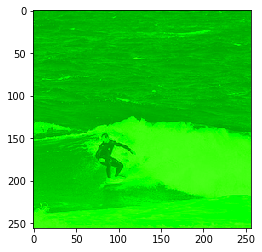

In [161]:
# converting into RGB gives us
im *= 255
imshow(YCCtoRGB(im))

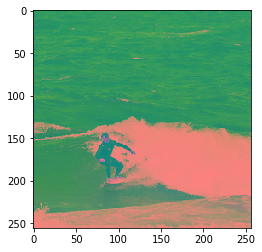

In [162]:
should_be = np.zeros_like(showoff_x)
should_be[:, :, 0] = original_x[:, :, 0]
should_be[:, :, 1] = showoff_y[:, :, 0]
should_be[:, :, 2] = showoff_y[:, :, 1]
imshow(should_be)

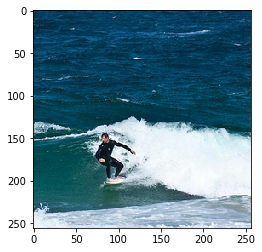

In [163]:
# real image
should_be *= 255
imshow(YCCtoRGB(should_be))